In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tiltFTSE import tiltFTSE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.distributions.empirical_distribution import ECDF

In [0]:
plPrice = pd.read_csv('plPrice17-19.csv')
plPrice.drop(columns = ['Hong Kong 8:30','Hong Kong 14:00','New York 9:30'],inplace = True)
plPrice.rename(columns = {'London 09:00':'Price'},inplace= True)
plPrice.dropna(how='any',inplace = True)
plPrice.to_csv('plPrice17-20Updated.csv')
plPrice['Date'] = pd.to_datetime(plPrice['Date'])
plPrice=plPrice[plPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]

In [0]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]

simulatedFTSE = pd.read_csv('fullSimulatedFTSEPrice.csv')
simulatedFTSE.rename(columns = {'Unnamed: 0':'Date'},inplace = True)
simulatedFTSE['Date'] = pd.to_datetime(simulatedFTSE['Date'])


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)


In [0]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
tiltWeights['Weights'] = np.random.uniform(-2,2,tiltWeights.shape[0])

tiltedFTSE = tiltFTSE(tiltWeights)

In [0]:
#Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
simulatedFTSE2019=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()) & (simulatedFTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date())]
FTSE2019=FTSE[(FTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()) & (FTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date())]

#Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
#

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE[0])

#correlation between real FTSE and pl price
correlationFTSE = pearsonr(FTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between real FTSE price and Pl price: ',correlationFTSE[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE = pearsonr(simulatedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between simulated (untilted) FTSE and Pl price: ',correlationSimFTSE[0])

#will only use simulated untilted FTSE price from now on

#Find mean squared error between pl price and tilted/simulated FTSE
mseTilt = mean_squared_error(plPrice19['Price'].values,tiltedFTSE2019['Open'].values)
mseSimu = mean_squared_error(plPrice19['Price'].values,simulatedFTSE2019['Open'].values)
print('\nTilt MSE',mseTilt,'\nSimulated FTSE MSE' ,mseSimu, '\nPercentage improvement',(1-mseTilt/mseSimu)*100,'%' )

#find daily percentage changes for tilted FTSE , untilted simulated and pl price
percentageChangeTilted = ((tiltedFTSE2019['Open'].shift(-1) / tiltedFTSE2019['Open']) - 1).reset_index()
percentageChangeSimuFTSE = ((simulatedFTSE2019['Open'].shift(-1) / simulatedFTSE2019['Open']) - 1).reset_index()
percentageChangePl = ((plPrice19['Price'].shift(-1) /  plPrice19['Price']) - 1).reset_index()

#find the difference in daily percentage change between pl price and both Tilted FTSE and simulated untilted FTSE
PCDiffTilt = (percentageChangePl['Price'][:-1] - percentageChangeTilted['Open'][:-1])
PCDiffSim = (percentageChangePl['Price'][:-1] - percentageChangeSimuFTSE['Open'][:-1])

#find corrleation between daily percentage changes for pl price and tilted FTSE
print('\nPercentage Change correlation - tilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeTilted['Open'][:-1])[0])
print('Percentage Change correlation - untilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeSimuFTSE['Open'][:-1])[0])

#plot of the daily percentage change difference between [pl and tilted] and [pl and untilted] 
plt.figure(1)
plt.plot(PCDiffTilt.index.values, PCDiffTilt)
plt.plot(PCDiffSim.index.values, PCDiffSim)

#histogram of daily percentage change difference
plt.figure(2)
plt.hist(PCDiffSim)
plt.hist(PCDiffTilt)
plt.show()


In [0]:
#this one takes ages to run don't do it, run the next one instead
dart_coef=[]
for i in range(1000):
    tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
    tiltWeights['Weights'] = np.random.uniform(-2,2,tiltWeights.shape[0])

    tiltedFTSE = tiltFTSE(tiltWeights)

    #Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
    tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
    
    #Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
    #

    #find correlation between tilted FTSE and palladium price
    correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
    
    # add correlation to sample list
    dart_coef.append(correlationTiltedFTSE[0])


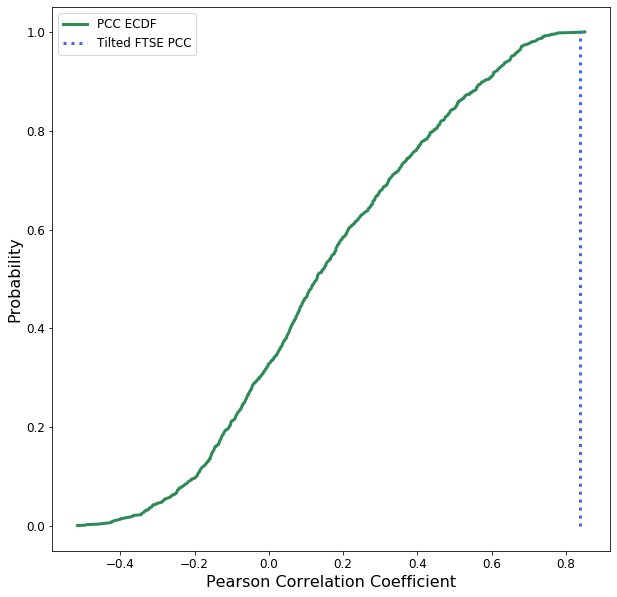

In [26]:
# generated from the above code, 2019 individual stocks
dart_coef=[0.27924888489426236, 0.473304320839548, -0.04577660856341976, 0.3576380981293174, -0.03393625314560254, 0.03369396487777625, 0.014347817365428655, 0.1155729002146832, 0.025467538103457067, 0.07198713739379221, 0.04943961456066684, 0.299813254458141, 0.07774951201181904, -0.10720236112653961, 0.4780868091891681, -0.32317331914617015, 0.3453064272201678, -0.2502353155822604, -0.05450327188816216, -0.19200538138272424, -0.10667899724678395, -0.1576767693233565, -0.1413538682927435, 0.38047265457664947, 0.3606867135401547, -0.0575510413165797, 0.4139025526760055, 0.21005445452096788, 0.4521479149740242, -0.18792815553245124, 0.36581007722835246, -0.20888915339280467, 0.40869516785494064, 0.013611828615108977, 0.7363646120110631, -0.0676542395350564, 0.5045966361652077, -0.26470171959085753, 0.45572380115097766, 0.24105936469727907, 0.3079950694282097, 0.4710075260477133, 0.10413563597888498, 0.4592953948464028, 0.40281615509749125, -0.10234498388839015, 0.03147376680476434, 0.6431937857744081, 0.03598099125900926, -0.3022633466015926, 0.4266101218467759, 0.4128768167812543, 0.45414850968990567, -0.17728738360569446, 0.6351054778421349, 0.2346631189330205, 0.5489265235205633, 0.09197498766347766, -0.13299741354279737, 0.3481163950614284, 0.3316631581605225, 0.35072922752371627, 0.46095826378646637, 0.4753999840550137, -0.1087347902805526, 0.625399762072038, -0.16034824624433228, 0.3253458571964088, -0.01266526753049381, 0.6160862387587197, 0.5194231875479087, -0.09817769057971491, 0.5612320433914204, -0.0015515338263164605, 0.0007168596691746248, 0.6733943117112735, -0.15503350962256526, 0.386338450899388, 0.5129853136798168, -0.07842872914515744, 0.4091277655917858, 0.023303136909801264, 0.10092312513592756, 0.20578572289676844, 0.4830289539227773, -0.0680757824953522, 0.04164909759896396, -0.07775117361799246, 0.44060946229325526, 0.17929445460259785, -0.11383078117214629, 0.5809487676126236, 0.5059557317687399, 0.04806796815892891, 0.49478536263558204, 0.22245552436054788, 0.6212405863313694, 0.17723273909595902, -0.015700231398025653, -0.1188442299597898, 0.6412797428808257, -0.007191212471420417, 0.08753094147002509, 0.34047325820109764, 0.5557471112827952, 0.13260170194482274, 0.038992501835735674, 0.16301009788281326, 0.29450388035219877, -0.12853636701490478, -0.34433185229265734, 0.10373165763958994, 0.11433994385974358, 0.11477118802360065, -0.1469685996029353, 0.2144026923149726, 0.047952775685701485, 0.07371830655928888, 0.6506177520734586, -0.13513036413305338, 0.18024317393090195, 0.0686242588919771, -0.01604852849790564, 0.4206160958832295, 0.48794021587240793, -0.04751348517371091, -0.23462665512605257, 0.5715798924420041, 0.7164055508613718, -0.07182199987585652, 0.27942383597384945, -0.02423346233675811, 0.6861454971151433, 0.07808754825859895, 0.7193632294356025, -0.3040534145158665, 0.5015743902966074, 0.014198558968904493, -0.16988578132803367, -0.3911638048174319, -0.0848126455400201, -0.13588433140398298, -0.044117008055541036, -0.057732879638334636, -0.1300413049739449, -0.35946382421585055, -0.2238522062440884, 0.03718783057332594, -0.10266514176035138, 0.03960356744301792, 0.509514514442968, 0.06056321448047852, 0.1318306170120751, -0.03735421776889114, 0.14254121047015658, -0.12819242334029968, 0.3094719022231357, 0.21262630622982615, -0.2612300338872612, 0.5416213620151327, 0.19484616933004462, 0.39927155600968584, 0.47448149816580615, 0.5315919053791232, -0.05856271275811718, 0.3251048616615356, 0.002702525777100784, -0.04164717516775046, 0.1597341968501108, 0.5073088660029751, 0.18125761359045295, 0.051060112913672004, 0.279169937877315, 0.741633080700075, 0.16415746577825635, -0.2292656079215645, -0.03617715666288578, -0.4893385313422427, 0.02949384534492548, 0.2625296738100231, -0.0747230639150155, 0.6341234134679106, -0.4493125269227924, 0.5942546498520931, 0.3815510626610008, 0.15348283002001262, 0.28359312809533144, 0.07401584211253037, 0.5422406433835221, 0.27424713678968204, -0.11608436622835576, 0.058577766767660286, 0.4064738018155049, -0.3124240421673977, 0.43279119249574355, -0.149285493492781, 0.15576396713436624, 0.09681124377641573, 0.31939154381491464, -0.04628138235042744, 0.8508476921533208, 0.5702325084619474, 0.734117532507943, 0.07483517456148434, -0.11342691162495805, 0.09368700688839507, 0.11264926167100069, 0.5625524516752543, 0.18418124467454972, 0.1503016912302435, 0.02802323616240926, -0.0019740706853572237, -0.03236359445923406, -0.004843453525127783, 0.1287956759454521, 0.4405957828155143, 0.7200228118640694, -0.07765941237558308, -0.23452070486174614, 0.34593266157977154, 0.08174608158977087, 0.20842683629742087, 0.6159214554044365, -0.3668921831433363, -0.4255432053022967, 0.09249860460648886, -0.08747584519826311, 0.010987842004598698, -0.09462855733952036, 0.2801804182971295, -0.05119998346152199, 0.5317892774988269, 0.23766177356001308, -0.33313845274657405, 0.05467940167708455, 0.2797377468913034, -0.36747058061458054, 0.32230680575681236, 0.29903064081271025, 0.5096362543617343, -0.33241018250244264, 0.6783410414132746, -0.39953756097081905, 0.26787981538857963, -0.1571744105714507, -0.04562526521799675, 0.03743396041580257, 0.10633255033634051, -0.285646949546127, -0.30255742543729147, 0.33964457585094715, 0.2849230583845016, 0.59666150885246, -0.08954213784886525, 0.2934864399203806, -0.4185279081321458, 0.7747499103762985, -0.23146611757472385, 0.01582956927195454, 0.11402572639748768, 0.6792668131072661, -0.31302015226692237, 0.45275672650371973, 0.21577373465587846, 0.6284876210257939, 0.1575717329611428, -0.11825393941458558, -0.4085451661114376, 0.29684591946488487, -0.15768179120336534, 0.22595116558512776, 0.5473428599044171, 0.5266636065686794, -0.07447221576179411, 0.4695983028057504, 0.3646582046664748, 0.6523731754368336, -0.12070176503594399, -0.16280774444682375, 0.12182031465052784, 0.1308536911993049, -0.14543005277838889, 0.28606342913889304, 0.46293818426061273, 0.22888277018944764, 0.47872108296046284, 0.17038786051375338, 0.24660602073534543, 0.33018923249702226, -0.4235013955677075, 0.03985989850136544, -0.16486957203441355, 0.4071581535664607, 0.2525438088865033, 0.07579922634703663, 0.6325912532131938, 0.4878262421719841, 0.16846592263903765, 0.15389235815302985, -0.10373368844763384, -0.15009485500793257, 0.4095616287299252, 0.14109891775236466, 0.41065265283830493, -0.1568777992056577, 0.049581207571776906, -0.13365904059989708, 0.0627985739618908, 0.15055654686854733, 0.025304262408515563, 0.33294249550788324, 0.4740742068121977, 0.18321159880838425, 0.19852237028437986, 0.6081008263963376, 0.5635131573811816, 0.1746147695331688, 0.06053924171604758, 0.23133666132547265, 0.24527906222123463, 0.6524609839454947, 0.35895815259803776, 0.18754225338556013, -0.14815893880805606, -0.3832150891848376, -0.31422028921159123, -0.0830466142620681, 0.48637517880205594, 0.759204004457967, 0.02304028661223184, 0.0035806930692629246, -0.13371257879480927, 0.4298874061708922, -0.24731961007479242, 0.3743237513723345, 0.04735632151379815, -0.33722057592154253, -0.3362105570144359, 0.3186333796127634, 0.36197783969519237, 0.05294049989093094, 0.05600129404513998, 0.054189201572258636, 0.43407838570527724, -0.18376118981215125, -0.01111420728915271, 0.11668617139691087, 0.5800021602662448, 0.20719760445930108, -0.20879004213326718, -0.01870542723277531, 0.5591941881652026, 0.7076072205235393, -0.05904241585578076, -0.1867234232921655, -0.39848889763474754, 0.08307672269220703, 0.14675322377188804, 0.4453805455635287, -0.3246517237144969, 0.15298772810436018, -0.15583469002879907, -0.13909037508001737, -0.12387090029674418, -0.16696325037926701, 0.6980251091346168, -0.029282289916647802, 0.1912959011242945, 0.5261800808588939, 0.5273840293321074, 0.19879591851835063, -0.07556666033277412, -0.1499303846461302, -0.12532741649103518, 0.16897029127199906, -0.12148525247038622, 0.26803972578445845, 0.4334352604813214, -0.06291619078050098, -0.24614769501044076, -0.20407310100121467, 0.11578516058749791, -0.13224348940719838, -0.17438550367435485, 0.17977897245326466, 0.5072466701988522, 0.10133473368048293, -0.021355628402169948, 0.8255084527963021, -0.10613333836087377, -0.1764006315823899, 0.30334065255361553, 0.21036231285787982, 0.18875819897166354, 0.6663575210445339, 0.42767335137627294, 0.28867277146888526, 0.6051326972737803, 0.3876629764030809, 0.18210807664849765, 0.5132617000543869, 0.489384093934455, 0.6891115115898463, 0.13117297181568213, 0.08036087921973299, 0.07879384034870598, -0.15125776176811406, -0.040740343302747443, -0.06409137265534308, 0.49587889199276625, 0.0739082910776029, 0.29706216967488774, 0.3912530171091007, 0.2681453833634997, 0.025024642606775456, 0.47279637697698457, 0.23134005798467716, 0.6008472797636557, 0.15351865165352366, -0.19220717947262791, -0.42367094053149196, 0.48318692097033195, 0.649104877091917, -0.09878325846628505, 0.03642691198971636, -0.08090275354073323, 0.38381265071368764, -0.19818415286410773, 0.060036995046685325, 0.7370948961964281, 0.6129407318093638, -0.3161769088411024, -0.09163170031775038, 0.0376259904986696, 0.40314569794505023, 0.5626771771568326, 0.2432471499434551, -0.40510305055091467, 0.25557792461338413, 0.3223821393527757, -0.2124971822263316, -0.13486344341780884, 0.13012685247823008, 0.3973052223761271, 0.605022638692701, 0.45476036902407957, 0.509539640736894, 0.39071752394899195, 0.4281404481759685, 0.07680754197187457, 0.17721842218871517, 0.572038750222893, 0.6048519996023377, 0.14486690142446013, -0.1464272350585546, 0.28578846524411416, 0.4339637934773969, 0.6638870986114023, -0.2688273573587899, 0.04834508007779267, 0.06619277509721282, 0.3743389677069642, -0.18637145215377549, 0.33637622925682, -0.12785169438592467, 0.3374224405300141, -0.16352266024598863, 0.4909857681543357, 0.402838404514016, -0.16046937719298446, 0.6801652754319901, -0.08339931062434044, 0.2119087796258502, 0.02171382414630814, 0.5025520169874887, -0.08629986524217378, -0.0483702509797681, 0.5591481074793276, 0.2404154803048285, -0.017569126946912053, 0.09602996996701962, 0.28681368788387807, 0.180213250284605, 0.5753051862142498, -0.3318913317377584, 0.1550007428015539, 0.043880123125888015, 0.17471238990098306, 0.5071652170451216, 0.3156576326830595, 0.1808551597636746, 0.5300680722393929, 0.16739925027344355, -0.45918614507560274, -0.0033367658358635748, -0.05475983229690505, 0.2755422933023784, -0.007523769624975971, -0.07344484517831287, -0.05191282397175122, 0.029071227404017554, 0.6665881596788472, 0.006576709284908146, -0.1096000316620237, -0.2266957831096797, 0.11886362467789761, -0.182256678838628, -0.3242232800970797, 0.18357919945244022, 0.13517571978163967, -0.31670944457545114, 0.404826888573665, 0.27382573690838474, 0.27321931892532914, 0.2968541423258349, -0.01049338632239457, 0.5062861558261466, 0.029595799130363646, 0.06378641789593506, 0.1768735160735494, 0.35609389559649085, 0.06855956513285298, 0.04233377874184978, -0.0607800914768488, -0.05407564333936439, -0.022139168952802386, 0.0299409887314801, 0.5641399033283034, 0.5581471025650938, 0.07216762426572679, 0.40909892917262247, 0.6311249796989106, -0.17036551625737062, -0.31464149774759587, -0.1028583425606289, 0.37028768087679753, 0.11152708893009632, 0.37935194296057084, 0.25417438893461247, -0.21522437664007682, -0.1672846674428407, 0.6537924076053119, -0.07204272921018087, 0.6243505851868136, 0.07627628827002908, -0.10325294846460212, 0.10816804998283147, -0.1895676289585424, -0.09155165019868534, 0.46219074324452125, -0.19330327641209866, -0.09269756415501688, 0.16451132972797644, 0.10947438322139735, 0.004465744493268028, 0.07891470484204557, 0.370139260786296, 0.6397087569113029, -0.17123335186149863, 0.08045087991085952, -0.002222966373346802, 0.005570453586026378, 0.5681515983792613, 0.6505290243990135, 0.4458213613739852, 0.16096924556312883, -0.08932676444389889, 0.1994716933582274, 0.0717914320196766, 0.2789917466740891, -0.2793017124128313, 0.031600584459356346, 0.041596141329961936, 0.035299394899841324, 0.4596546361806206, 0.005675119581071133, 0.05543994269658908, -0.1556421610619458, -0.27639169927361673, 0.0901386455041464, -0.06537885701102197, 0.46139093033206685, -0.1069580070644479, 0.22237969433953525, 0.1276310865516049, 0.43052720797096977, 0.4186776168298195, -0.10271343125566415, 0.12852038867007504, -0.1860068713984036, -0.15290773290699122, 0.28765001011538227, 0.14927881010938576, 0.4736156188858685, 0.5180831658794393, 0.37850983323344956, -0.19778901222286893, 0.3210967384747695, -0.05826517401050137, 0.37086880764966945, 0.4818448818034248, -0.4940503398757364, -0.1734628812227365, 0.38888026728825265, -0.2638115571834423, -0.0474929706067862, 0.2941866926920632, 0.7052458254643124, 0.011321623201288546, -0.07229954720977055, 0.6631438146201386, 0.12134376071899058, -0.12110098846548058, -0.15738185497695883, -0.0406554169773006, 0.14488175019159028, 0.4507183843687135, 0.3521544690366475, 0.13053162431291712, 0.3225734893080935, 0.371225597179928, 0.45439112925112235, -0.07479615109582431, 0.032811080586009775, 0.1908823714127724, 0.5002482675676028, -0.2631524544551575, 0.6327360247856892, 0.28498644133278295, 0.3072870862877659, 0.09941343274433198, 0.18985689778001305, 0.11633928496488483, 0.09631273130938939, 0.08215779285013694, -0.3433541088640092, 0.18528870324523272, -0.07983617419772818, 0.12455067756222851, 0.36050966693654163, -0.031627385308696465, -0.05340753804069098, 0.1481996375745251, 0.6467233726313375, 0.6782505311203983, -0.12643486936130205, -0.12260063884309326, 0.2581473711967559, -0.24684936405096947, 0.6969956847828505, 0.60990313918171, 0.5586355938913907, -0.03601413428207367, -0.24192077872615442, 0.1506838047498225, 0.06562603559571602, 0.30415923599163347, -0.05985102824848478, -0.15316732261669797, 0.2602841953222938, -0.20932193736728444, 0.7005442857323527, -0.1476435266468636, 0.19692365771762316, 0.2895908957951258, 0.5802012087263867, 0.39860005575097407, -0.011358414829102534, 0.5582326854107058, -0.2367230762062193, 0.21330706475559214, 0.4294841156270645, 0.23063840749326356, -0.3692888588082113, 0.48843838480517643, 0.17143815351233996, 0.7414939268649121, 0.35585729948640493, 0.31279262012696246, 0.19259850763061737, 0.2812000093317769, 0.05790927344041708, -0.2464312300184253, 0.6002710627546106, 0.1301665476420747, -0.16015207779307883, 0.6766994118331656, -0.43729596867205317, 0.02018945970213295, -0.06574624004648129, 0.22328042733207187, 0.20308452670780908, 0.15656797031159458, 0.6001364388097941, -0.13537906000108707, 0.08253124993706579, 0.3972818460469617, -0.18110492581382986, 0.661422277163478, -0.18286467739028814, 0.3270144164440649, 0.10520883191180169, 0.01714667001502875, 0.23747771420480607, 0.3573545384320852, 0.3999059270775665, 0.5217985137153139, 0.07189106480860205, 0.5512381820121209, 0.09230211587400336, 0.5037860361468205, 0.43781048844057413, -0.0022866987526818025, 0.08391429957482481, 0.08352414001709363, 0.22904893859162817, 0.48062680249772555, 0.5841081247422362, -0.2887506725487298, 0.7519360945550131, 0.4030473524144771, -0.024038060370293626, 0.06512378179387676, 0.6026050619425765, 0.2789944864614756, 0.11885250005337791, 0.6181563282606737, 0.48506828909107513, -0.14461769592627646, -0.04293938148288517, 0.11936505378796164, -0.15472089512019577, 0.1681389446720931, 0.38544679412247557, -0.2709536272413603, 0.3498693571188046, -0.05233569484545165, -0.0632339601261162, 0.24488666272981913, -0.12692234066606284, -0.13028882964379754, 0.18033447637423927, -0.08859906576251453, -0.026869226861047868, 0.7790729775892616, 0.1802133669278265, 0.08695339235183068, 0.08941793559833562, -0.10815092525249438, 0.6748339954512026, -0.25406547981166694, 0.19722335096319538, -0.2815233315304267, 0.10327834554409976, -0.28681183634957497, 0.22127753366055672, -0.15413543524018658, 0.24764738991270924, 0.0639191894208785, 0.2984465140041429, 0.5486356911384584, 0.19621267689701655, 0.3846253829620705, 0.3971194025899771, 0.10399405763152375, 0.08342821382259874, 0.3503002500434109, 0.13346273281075208, 0.3544428174476012, -0.19594723041988868, -0.09032879512766563, -0.2607697549226947, 0.34481529145905887, 0.3070423341693236, -0.24153014125187902, 0.2657500410186726, 0.045955900517107046, 0.5252443317224653, 0.05048511770253812, 0.20416858067788096, 0.6716455075620984, -0.01273226190416791, 0.12717342352459413, 0.31906658661410536, -0.06092040645453895, 0.18859873007272374, 0.2956966426928124, 0.04738803517103852, 0.6208258904444282, 0.1425811929885112, 0.08923153378947607, 0.35734076255995467, -0.14022850360823325, 0.380434799191604, 0.05757709740825201, 0.17659848074575785, -0.018670300626809078, 0.5413434503941378, -0.281436803662104, 0.12943659499609594, 0.20881075017569556, 0.2671216542593871, 0.5951032511545201, -0.044887606841084525, 0.053842947076946215, 0.6845878682933245, 0.05643659918582282, -0.08556700150901489, 0.02662877872108053, 0.6050852512475513, 0.10539047744809057, 0.12290974818629569, 0.3180246783340711, 0.05772517830428413, 0.5193125234989777, 0.2424896632940706, -0.12670763412354707, 0.46406077286898384, 0.28509122517209556, -0.28891902253405655, 0.06849106128515997, 0.4190036033599678, 0.3227938464040375, -0.06206448794734068, 0.6802881438645633, 0.12380672860814725, 0.649372628521092, -0.25343484626220314, 0.32073454595203543, 0.10326508583841365, 0.21600096309738728, 0.09587541827147299, 0.09283329357491055, 0.6518293482983422, 0.26580687132566744, -0.19181706271928173, 0.46056624393653256, 0.10250956927272983, 0.07044400112579946, -0.12837707044674004, 0.08508867319025325, -0.3437330163943026, -0.1915778776746842, -0.01503843222604876, 0.7234274415256954, 0.02050085558416781, 0.08873661518496465, -0.061409052801023274, -0.07063025915884466, 0.10873767751958775, 0.6047939490273739, 0.21482963316218018, 0.6620421299346919, 0.3662545545141506, 0.4248043654390171, 0.3530809841129579, 0.45457453446991525, 0.5586852069701145, -0.06439041571376664, -0.22004643179380384, -0.4169826189673029, -0.11964886214463256, 0.20795793703383278, 0.44266287571945917, 0.05988625426063714, 0.6195077386051024, 0.06135992743959375, -0.33891188401539873, 0.3334319925292557, 0.21831707837584258, 0.020460519215910574, -0.045547582667761585, 0.7370930894832344, 0.0835251148309401, 0.2695734047431997, -0.2186820175332783, 0.44582689142293214, 0.3693698271304801, 0.591074955823677, 0.4337488258174244, -0.07212536873439132, -0.05460522772117818, 0.39372978574000517, 0.10838276544724543, 0.6516299045071346, -0.14469507419680316, -0.34103837438667944, -0.24372920405324044, -0.13301013514611917, 0.18441854566398397, -0.28280075349354, 0.5091922145791459, -0.02708600646420219, 0.10680035545218251, -0.026835282861327983, 0.1306181073708783, 0.06387717742882959, 0.32934078438782477, 0.25707292986599883, 0.42706859234132477, 0.7063142516845249, -0.32152184305204345, 0.20567991888151452, 0.010819472855919318, -0.21714010856073362, -0.18626106389931893, 0.4610522042842896, 0.013841773838709704, 0.1415684174936364, -0.0016349930126023354, -0.1907040847272889, 0.5712456359954151, 0.27484426296458847, 0.15003527044955084, -0.0910470594897704, 0.6779276600485409, 0.541347941283151, 0.12265987854459909, 0.6791345474403956, 0.08843885582205674, 0.6571695928056107, 0.19204216816816772, 0.1543757671503273, -0.1949344997144671, 0.6037785424232047, 0.3056123605213521, -0.02051935676107213, 0.5255195490525653, 0.6150431916821193, 0.05217519646383967, -0.15477468514569948, -0.22749301679952263, -0.07035864749841955, -0.17998274496202793, -0.37559181952648574, -0.1309182588363717, -0.009875930528206178, 0.046823754638506965, 0.08917825248688807, -0.08873108838117605, -0.031186668724953036, 0.16699583848601254, 0.4334936985543939, 0.6713279509136566, -0.2179863192419915, 0.21347517965518065, 0.3157888740554575, -0.12194427806197278, -0.1852789534685502, 0.2397151752284752, 0.3211699895924415, 0.23326696937273717, -0.2488224940150885, 0.16718830681216612, -0.3228165650361383, 0.05483063955590137, 0.63527064092606, 0.3326546079962469, 0.7227763123477041, 0.32842251546864554, -0.1630351850391723, 0.7599397863168537, 0.18858815154521205, 0.3509868934431124, 0.5942896640460829, 0.7270220311215656, -0.045032334720424436, 0.16422930986956824, 0.3073913412325352, -0.05031365306218858, 0.29331438971451745, -0.10351722483739063, -0.2499473303147457, -0.24780096900533052, 0.2109350731366872, 0.7736202294825043, 0.27276403756277184, -0.0063059985631777945, -0.006690376302032824, -0.29530500487523703, 0.25008300629000396, -0.10312579624830948, -0.24203064611497635, 0.024007114840363948, -0.1008791011944009, 0.14129847865955286, 0.5024981850762393, -0.08464459520394751, -0.05057617458260205, 0.4869873912139343, 0.6677306538005052, -0.14674043618132254, 0.13394017015416537, 0.24781208380166153, 0.03579264988479326, -0.19993187629311024, -0.1692670470783163, 0.6264618054521898, -0.5154048342672483, -0.22246771004971183]
#plt.hist(dart_coef, bins=20, density=True)

ecdf=ECDF(dart_coef)
plt.figure(figsize=(10,10))
plt.plot(ecdf.x, ecdf.y,c='seagreen',label = 'PCC ECDF',linewidth = 3)
plt.plot([0.839,0.839],[0,1],':',c='royalblue',label = 'Tilted FTSE PCC',linewidth = 3)
#plt.plot([-0.5,0.839],[0.999,0.999],":",c='royalblue')
plt.ylabel('Probability',fontsize = 16)
plt.xlabel('Pearson Correlation Coefficient',fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig('ECDFTilt19.png',dpi=80)
plt.show()

In [0]:
test_tilt=0.839
print(ecdf(test_tilt))